In [ ]:
import pandas as pd
import nannyml as nml
reference, analysis, analysis_targets = nml.datasets.load_modified_california_housing_dataset()
reference.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,timestamp,period,clf_target,y_pred_proba,y_pred,identifier
0,9.8413,32.0,7.170040,1.014845,4353.0,2.937247,34.22,-118.19,2020-10-01 00:00:00,reference,1,0.99,1,0
1,8.3695,37.0,7.458746,1.062706,941.0,3.105611,34.22,-118.21,2020-10-01 01:00:00,reference,1,1.00,1,1
2,8.7200,44.0,6.163180,1.046025,668.0,2.794979,34.20,-118.18,2020-10-01 02:00:00,reference,1,1.00,1,2


In [ ]:
print(reference.head(3).to_markdown(tablefmt="grid"))

+----+----------+------------+------------+-------------+--------------+------------+------------+-------------+---------------------+-----------+--------------+----------------+----------+--------------+
|    |   MedInc |   HouseAge |   AveRooms |   AveBedrms |   Population |   AveOccup |   Latitude |   Longitude | timestamp           | period    |   clf_target |   y_pred_proba |   y_pred |   identifier |
+====+==========+============+============+=============+==============+============+============+=============+=====================+===========+==============+================+==========+==============+
|  0 |   9.8413 |         32 |    7.17004 |     1.01484 |         4353 |    2.93725 |      34.22 |     -118.19 | 2020-10-01 00:00:00 | reference |            1 |           0.99 |        1 |            0 |
+----+----------+------------+------------+-------------+--------------+------------+------------+-------------+---------------------+-----------+--------------+----------------+--

In [ ]:
# fit performance estimator and estimate for combined reference and analysis
cbpe = nml.CBPE(
    y_pred='y_pred',
    y_pred_proba='y_pred_proba',
    y_true='clf_target',
    timestamp_column_name='timestamp',
    problem_type='classification_binary',
    chunk_period='M',
    metrics=['roc_auc'])
cbpe.fit(reference_data=reference)
est_perf = cbpe.estimate(pd.concat([reference, analysis]))

In [ ]:
est_perf.data['end_index'] - est_perf.data['start_index']

0     743
1     719
2     743
3     743
4     671
5     743
6     719
7     743
8     743
9     719
10    743
11    743
12    671
13    743
14    719
15    743
16    719
17    743
18    743
19    719
20    743
21    719
22    743
23    743
24    671
25    743
26    719
27    215
dtype: int64

In [ ]:
est_perf.data = est_perf.data[:-1].copy()
est_perf.data.tail(2)

,key,chunk_index,start_index,end_index,start_date,end_date,realized_roc_auc,estimated_roc_auc,upper_confidence_roc_auc,lower_confidence_roc_auc,sampling_error_roc_auc,upper_threshold_roc_auc,lower_threshold_roc_auc,alert_roc_auc,period
25,2022-03,17,12384,13127,2022-03-01,2022-03-31 23:59:59.999999999,NaN,0.829077,0.852420,0.805734,0.007781,1.0,0.708336,False,analysis
26,2022-04,18,13128,13847,2022-04-01,2022-04-30 23:59:59.999999999,NaN,0.910661,0.934389,0.886932,0.007910,1.0,0.708336,False,analysis


In [ ]:
print(est_perf.data.tail(2).to_markdown(tablefmt="grid"))

+----+---------+---------------+---------------+-------------+---------------------+-------------------------------+--------------------+---------------------+----------------------------+----------------------------+--------------------------+---------------------------+---------------------------+-----------------+----------+
|    | key     |   chunk_index |   start_index |   end_index | start_date          | end_date                      |   realized_roc_auc |   estimated_roc_auc |   upper_confidence_roc_auc |   lower_confidence_roc_auc |   sampling_error_roc_auc |   upper_threshold_roc_auc |   lower_threshold_roc_auc | alert_roc_auc   | period   |
+====+=========+===============+===============+=============+=====================+===============================+====================+=====================+============================+============================+==========================+===========================+===========================+=================+==========+
| 25 | 202

In [ ]:
fig = est_perf.plot(kind='performance', metric='roc_auc')
fig.show()

In [ ]:
fig.write_image(file=f"../_static/example_california_performance.svg")

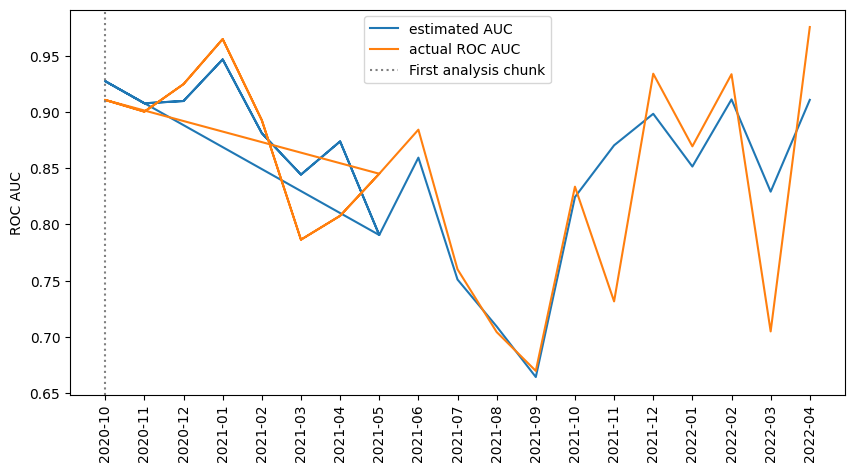

In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
# add ground truth to analysis
analysis_full = pd.merge(analysis, analysis_targets, on = 'identifier')
df_all = pd.concat([reference, analysis_full]).reset_index(drop=True)
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
# calculate actual ROC AUC
target_col = cbpe.y_true
pred_score_col = 'y_pred_proba'
actual_performance = []
for idx in est_perf.data.index:
    start_date, end_date = est_perf.data.loc[idx, 'start_date'], est_perf.data.loc[idx, 'end_date']
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    actual_perf = roc_auc_score(sub[target_col], sub[pred_score_col])
    est_perf.data.loc[idx, 'actual_roc_auc'] = actual_perf
# plot
first_analysis = est_perf.data['key'].values[0]
plt.figure(figsize=(10,5))
plt.plot(est_perf.data['key'], est_perf.data['estimated_roc_auc'], label='estimated AUC')
plt.plot(est_perf.data['key'], est_perf.data['actual_roc_auc'], label='actual ROC AUC')
plt.xticks(rotation=90)
plt.axvline(x=first_analysis, label='First analysis chunk', linestyle=':', color='grey')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

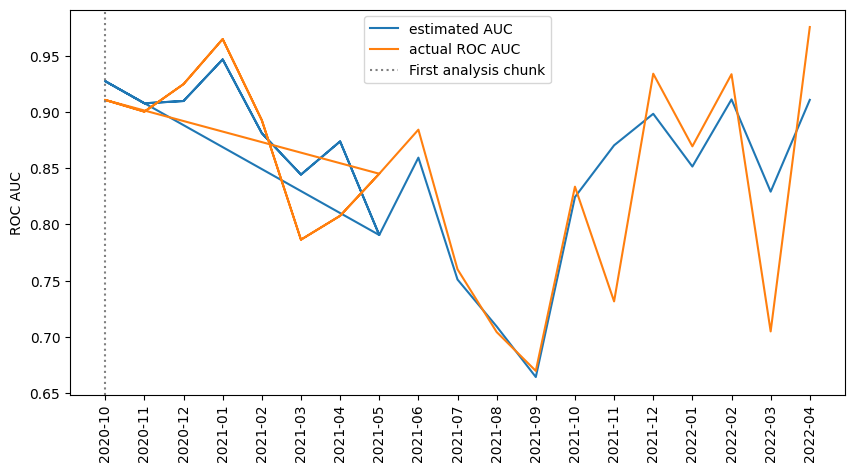

In [ ]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
# add ground truth to analysis
analysis_full = pd.merge(analysis, analysis_targets, on = 'identifier')
df_all = pd.concat([reference, analysis_full]).reset_index(drop=True)
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])
# calculate actual ROC AUC
target_col = cbpe.y_true
pred_score_col = 'y_pred_proba'
actual_performance = []
for idx in est_perf.data.index:
    start_date, end_date = est_perf.data.loc[idx, 'start_date'], est_perf.data.loc[idx, 'end_date']
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    actual_perf = roc_auc_score(sub[target_col], sub[pred_score_col])
    est_perf.data.loc[idx, 'actual_roc_auc'] = actual_perf
# plot
first_analysis = est_perf.data['key'].values[0]
plt.figure(figsize=(10,5))
plt.plot(est_perf.data['key'], est_perf.data['estimated_roc_auc'], label='estimated AUC')
plt.plot(est_perf.data['key'], est_perf.data['actual_roc_auc'], label='actual ROC AUC')
plt.xticks(rotation=90)
plt.axvline(x=first_analysis, label='First analysis chunk', linestyle=':', color='grey')
plt.ylabel('ROC AUC')
plt.legend()
plt.savefig("../_static/example_california_performance_estimation_tmp.svg")

In [ ]:
feature_column_names = [col for col in reference if col not in ['y_pred', 'y_pred_proba', 'clf_target', 'timestamp']]
univariate_calculator = nml.UnivariateStatisticalDriftCalculator(feature_column_names=feature_column_names,
                                                                 timestamp_column_name='timestamp',
                                                                 chunk_period='M').fit(reference_data=reference)
univariate_results = univariate_calculator.calculate(analysis)
nml.Ranker.by('alert_count').rank(univariate_results)

,feature,number_of_alerts,rank
0,AveOccup,20,1
1,Latitude,20,2
2,Longitude,20,3
3,identifier,20,4
4,MedInc,19,5
5,HouseAge,19,6
6,AveRooms,18,7
7,AveBedrms,15,8
8,Population,15,9
9,period,12,10


In [ ]:
ranked = nml.Ranker.by('alert_count').rank(univariate_results)
print(ranked.to_markdown(tablefmt="grid"))

+----+------------+--------------------+--------+
|    | feature    |   number_of_alerts |   rank |
+====+============+====================+========+
|  0 | AveOccup   |                 20 |      1 |
+----+------------+--------------------+--------+
|  1 | Latitude   |                 20 |      2 |
+----+------------+--------------------+--------+
|  2 | Longitude  |                 20 |      3 |
+----+------------+--------------------+--------+
|  3 | identifier |                 20 |      4 |
+----+------------+--------------------+--------+
|  4 | MedInc     |                 19 |      5 |
+----+------------+--------------------+--------+
|  5 | HouseAge   |                 19 |      6 |
+----+------------+--------------------+--------+
|  6 | AveRooms   |                 18 |      7 |
+----+------------+--------------------+--------+
|  7 | AveBedrms  |                 15 |      8 |
+----+------------+--------------------+--------+
|  8 | Population |                 15 |      9 |


In [ ]:
# get columns with d statistics only
d_stat_cols = [x for x in univariate_results.data if 'dstat' in x]
univariate_results.data[d_stat_cols].mean().sort_values(ascending=False)

identifier_dstat    0.874280
Longitude_dstat     0.712709
Latitude_dstat      0.672904
HouseAge_dstat      0.201638
MedInc_dstat        0.154952
AveOccup_dstat      0.143890
AveRooms_dstat      0.129277
AveBedrms_dstat     0.089140
Population_dstat    0.073562
dtype: float64

In [ ]:
print(univariate_results.data[d_stat_cols].mean().sort_values(ascending=False).to_markdown(tablefmt="grid"))

+------------------+-----------+
|                  |         0 |
+==================+===========+
| identifier_dstat | 0.87428   |
+------------------+-----------+
| Longitude_dstat  | 0.712709  |
+------------------+-----------+
| Latitude_dstat   | 0.672904  |
+------------------+-----------+
| HouseAge_dstat   | 0.201638  |
+------------------+-----------+
| MedInc_dstat     | 0.154952  |
+------------------+-----------+
| AveOccup_dstat   | 0.14389   |
+------------------+-----------+
| AveRooms_dstat   | 0.129277  |
+------------------+-----------+
| AveBedrms_dstat  | 0.0891403 |
+------------------+-----------+
| Population_dstat | 0.0735623 |
+------------------+-----------+


In [ ]:
for col in ['Longitude', 'Latitude']:
    fig = univariate_results.plot(
        kind='feature_distribution',
        feature_column_name=col)
    fig.show()

In [ ]:
for col in ['Longitude', 'Latitude']:
    fig = univariate_results.plot(
        kind='feature_distribution',
        feature_column_name=col)
    fig.write_image(f"../_static/example_california_performance_distribution_{col}.svg")

Text(0, 0.5, 'Longitude')

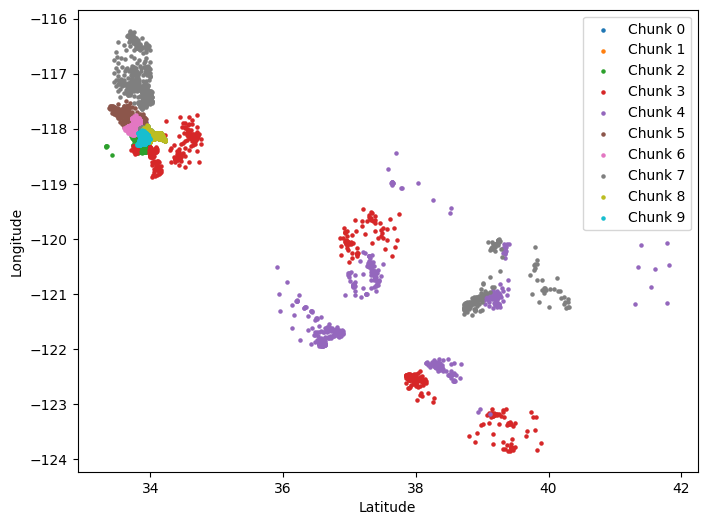

In [ ]:
analysis_res = est_perf.data
plt.figure(figsize=(8,6))
for idx in analysis_res.index[:10]:
    start_date, end_date = analysis_res.loc[idx, 'start_date'], analysis_res.loc[idx, 'end_date']
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    plt.scatter(sub['Latitude'], sub['Longitude'], s=5, label="Chunk {}".format(str(idx)))

plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Longitude')

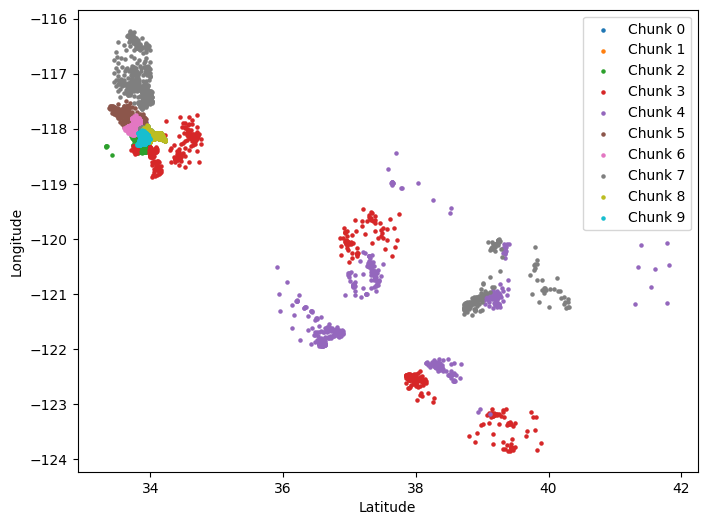

In [ ]:
analysis_res = est_perf.data
plt.figure(figsize=(8,6))
for idx in analysis_res.index[:10]:
    start_date, end_date = analysis_res.loc[idx, 'start_date'], analysis_res.loc[idx, 'end_date']
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    plt.scatter(sub['Latitude'], sub['Longitude'], s=5, label="Chunk {}".format(str(idx)))

plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Longitude')

plt.savefig("../_static/example_california_latitude_longitude_scatter.svg")
